In [3]:
### Workbook 4 - Implementing Salamon and Bello's Convolutional Neural Network 

This is a Keras/Tensorflow implementation of the 5-layer CNN described in Salamon and Bello's paper (https://arxiv.org/pdf/1608.04363.pdf).

First, import the libraries. As with the earlier notebooks, the audio processing is handled by a library called librosa, if you haven't already installed it on your local system, do that with: pip install librosa

In [4]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

If you're going to run this code with the full data set, this notebook assumes you've already run the feature extraction code in notebook 3. 

If you have a powerful computer, and don't mind the training process taking longer, you can set the all_folds flag to true - which will create a single large training set of 43722 examples, using the first 8 folds. 


In [5]:
data_dir = "data/us8k-np-cnn"

# this will aggregate all the training data 
def load_all_folds(): 
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        print "\nAdding " + fold_name
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print "New Features: ", loaded_features.shape

        if subsequent_fold:
            train_x = np.concatenate((features, loaded_features))
            train_y = np.concatenate((labels, loaded_labels))
        else:
            train_x = loaded_features
            train_y = loaded_labels
            subsequent_fold = True
        
    # use the penultimate fold for validation
    valid_fold_name = 'fold9'
    feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
    valid_x = np.load(feature_file)
    valid_y = np.load(labels_file) 

    # and use the last fold for testing
    test_fold_name = 'fold10'
    feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
    test_x = np.load(feature_file)
    test_y = np.load(labels_file)
    

# this is used to load the folds incrementally
def load_folds(folds):
    subsequent_fold = False
    for k in range(len(folds)):
        fold_name = 'fold' + str(folds[k])
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print fold_name, "features: ", loaded_features.shape

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

-----

### Training a Convolutional Neural Network with Keras and TensorFlow

First, the imports we need and a few configuration variables.

In [6]:
tf.set_random_seed(0)
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2

frames = 41
bands = 60
feature_size = bands * frames #60x41
num_channels = 2
num_labels = 10 # test_y.shape[1]

This method defines some evaluation metrics that will be used to evaluate the performance of a trained model.

In [7]:
def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    y_pred = np_utils.probas_to_classes(y_prob)
    y_true = np.argmax(test_y, 1)

    roc = roc_auc_score(test_y, y_prob)
    print "ROC:",  round(roc,3)

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.2f}".format(accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print "F-Score:", round(f,2)
    
    return roc, accuracy

This method contains the code that defines the successive layers of our convolutional neural network (CNN) described in this paper by Salamon and Bello: https://arxiv.org/pdf/1608.04363.pdf

In [8]:
def build_model():
    
    model = Sequential()
    # input: 60x41 data frames with 2 channels => (60,41,2) tensors

    # filters of size 3x3 - paper describes using 5x5, but their input data is 128x128
    f_size = 3

    # Layer 1 - 24 filters with a receptive field of (f,f), i.e. W has the
    # shape (24,1,f,f).  This is followed by (4,2) max-pooling over the last
    # two dimensions and a ReLU activation function
    model.add(Convolution2D(24, f_size, f_size, border_mode='same', init="normal", input_shape=(bands, frames, num_channels)))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Activation('relu'))

    # Layer 2 - 48 filters with a receptive field of (f,f), i.e. W has the 
    # shape (48, 24, f, f). Like L1 this is followed by (4,2) max-pooling 
    # and a ReLU activation function.
    model.add(Convolution2D(48, f_size, f_size, init="normal", border_mode='same'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Activation('relu'))

    # Layer 3 - 48 filters with a receptive field of (f,f), i.e. W has the
    # shape (48, 48, f, f). This is followed by a ReLU but no pooling.
    model.add(Convolution2D(48, f_size, f_size, border_mode='valid'))
    model.add(Activation('relu'))

    # flatten output into a single dimension, let Keras do shape inference
    model.add(Flatten())

    # Layer 4 - a fully connected NN layer of 64 hidden units, L2 penalty of 0.001
    model.add(Dense(64, W_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 5 - an output layer with one output unit per class, with L2 penalty, 
    # followed by a softmax activation function
    model.add(Dense(num_labels, W_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Activation('softmax'))

    # compile and fit model, reduce epochs if you want a result faster
    # the validation set is used to identify parameter settings (epoch) that achieves 
    # the highest classification accuracy
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adamax")
    
    return model

### Training on a minimised data set

The data set is a large quantity of data, which is quite computationally intensive to process. But if you've checked out the git repository for this project, I've included a selection from the original data set, which should allow you to run the CNN and see how it works. Obviously as this training set size is much smaller and contains much less diversity than the full set, lower accuracies will be achievable when models are trained on it, but it will allow you to run the code and explore how it works. 

In [20]:
# change this to data/us8k-np-cnn if you have the full dataset
data_dir = "data/us8k-np-cnn-mini"

# load fold1 for testing (or 1,2,3 if you have full data)
train_x, train_y = load_folds([1])

# load fold2 for validation (or 9 if full data)
valid_x, valid_y = load_folds([2])
    
# load fold3 for testing (or 10 if full data)
test_x, test_y = load_folds([3])

print("Building model...")
model = build_model()

# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

# now fit the model to the training data, evaluating loss against the validation data
print("Training model...")
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=20, nb_epoch=12)

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
roc, acc = evaluate(model)

fold1 features:  (5446, 60, 41, 2)
fold2 features:  (5388, 60, 41, 2)
fold3 features:  (5852, 60, 41, 2)
fold9 features:  (5118, 60, 41, 2)
fold10 features:  (5218, 60, 41, 2)
Building model...
Training model...
Train on 16686 samples, validate on 5118 samples
Epoch 1/12
16686/16686 [==============================] - 64s - loss: 2.1939 - acc: 0.2140 - val_loss: 2.0159 - val_acc: 0.2532
Epoch 2/12
16686/16686 [==============================] - 64s - loss: 1.9663 - acc: 0.3076 - val_loss: 1.9394 - val_acc: 0.3214
Epoch 3/12
16686/16686 [==============================] - 64s - loss: 1.7583 - acc: 0.3674 - val_loss: 1.8850 - val_acc: 0.3376
Epoch 4/12
16686/16686 [==============================] - 66s - loss: 1.6103 - acc: 0.4147 - val_loss: 1.8866 - val_acc: 0.3912
Epoch 5/12
16686/16686 [==============================] - 64s - loss: 1.4991 - acc: 0.4506 - val_loss: 1.8545 - val_acc: 0.4017
Epoch 6/12
16686/16686 [==============================] - 64s - loss: 1.4288 - acc: 0.4700 - val_lo

### Training on the full data set (intensive) 

This is the training process, it will create a fresh model for each trial, load the next fold of input data, fit it to the model and evaluate the accuracy achieved. When all the input data has been used, we can calculate the average accuracy for all the folds. The parameters used here have been chosen to allow computation to run on a reasonably powered laptop in less than 10 minutes. When running it on an 8-core high-memory cloud instance, more epochs and larger training sets can be used, this will produce greater prediction accuracy, but come at the cost of much greater training time.

In [12]:
data_dir = "data/us8k-np-cnn"
all_folds = False
av_acc = 0.
av_roc = 0.
num_folds = 0

# as we use two folds for training, there are 9 possible trails rather than 10
max_trials = 3

# earlystopping ends training when the validation loss stops improving
earlystop = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

if all_folds:
    load_all_folds()
    model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=32, nb_epoch=1)
else:
    # use folds incrementally
    for f in range(1,max_trials+1):
        num_folds += 1
        v = f + 3
        if v > 10: v = 1
        t = v + 1
        if t > 10: t = 1
        
        print "\n*** Train on", (f,f+1,f+2), "Validate on", v, "Test on", t, "***"
    
        # load two folds for training data
        train_x, train_y = load_folds([f,f+1,f+2])
    
        # load one fold for validation
        valid_x, valid_y = load_folds([v])
    
        # load one fold for testing
        test_x, test_y = load_folds([t])
        
        num_labels = test_y.shape[1]
        
        print("Building model...")
        model = build_model()

        # now fit the model to the training data, evaluating loss against the validation data
        print("Training model...")
        model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=24, nb_epoch=2)
        
        
        # now evaluate the trained model against the unseen test data
        print("Evaluating model...")
        roc, acc = evaluate(model)
        av_roc += roc
        av_acc += acc
    
print '\nAverage R.O.C:', round(av_roc/max_trials, 3)
print 'Average Accuracy:', round(av_acc/max_trials, 3)

# using all folds: best ROC = 0.91, f-score = 0.592 (50 epochs)
# using 2 folds: average ROC = 0.792, average f-score = 0.335

# if you want to save the model, uncomment this...
#filepath = "models/salamon-cnn-model.h5"
#model.save(filepath)


*** Train on (1, 2, 3) Validate on 4 Test on 5 ***
fold1 features:  (5446, 60, 41, 2)
fold2 features:  (5388, 60, 41, 2)
fold3 features:  (5852, 60, 41, 2)
fold4 features:  (6048, 60, 41, 2)
fold5 features:  (5689, 60, 41, 2)
Building model...
Training model...
Train on 16686 samples, validate on 6048 samples
Epoch 1/2
16686/16686 [==============================] - 74s - loss: 2.1965 - acc: 0.2171 - val_loss: 1.9184 - val_acc: 0.3054
Epoch 2/2
16686/16686 [==============================] - 67s - loss: 1.9443 - acc: 0.3093 - val_loss: 1.7758 - val_acc: 0.4347
Evaluating model...
ROC: 0.798
5689/5689 [==============================] - 9s     

Accuracy = 0.34
F-Score: 0.34

*** Train on (2, 3, 4) Validate on 5 Test on 6 ***
fold2 features:  (5388, 60, 41, 2)
fold3 features:  (5852, 60, 41, 2)
fold4 features:  (6048, 60, 41, 2)
fold5 features:  (5689, 60, 41, 2)
fold6 features:  (5080, 60, 41, 2)
Building model...
Training model...
Train on 17288 samples, validate on 5689 samples
Epoch 1

### Evaluating Predictions using a Pre-Trained Model

To save time, once trained, a model can be saved and reloaded to generate predictions. The following cell also shows a summary of the CNN we've created.

A pretrained model has been supplied, enabling us to run predictions without creating and training a model from scratch, if you want to use it, run the following cell:

In [9]:
from keras.models import load_model
from keras.utils.visualize_util import plot

model_filepath = "models/salamon-cnn-model.h5"
model = load_model(model_filepath)

plot(model, show_shapes=True, to_file='models/salamon-cnn-model.svg')
print model.summary()

data_dir = "data/us8k-np-cnn"
# model has never seen fold 10, so use that for testing
test_x, test_y = load_folds([10])
roc, acc = evaluate(model)
print '\nModel R.O.C:', round(roc, 3)
print 'Model Accuracy:', round(acc, 3)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_14 (Convolution2D) (None, 60, 41, 24)    456         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 15, 20, 24)    0           convolution2d_14[0][0]           
____________________________________________________________________________________________________
activation_20 (Activation)       (None, 15, 20, 24)    0           maxpooling2d_9[0][0]             
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 15, 20, 48)    10416       activation_20[0][0]              
___________________________________________________________________________________________

Using micro-averaging we can create an ROC measure for this multi-class classification problem, by converting the predictions into boolean values, each representing positive or negative predictions for each possible class. The resulting ROC plot is shown below.

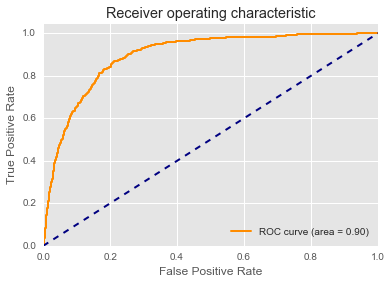

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
y_pred = np_utils.probas_to_classes(y_prob)
y_true = np.argmax(test_y, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

This saved model achieves an accuracy of 59%, and represents some of the best performance I've achieved with this particular neural network architecture.

Showing Confusion Matrix
              air-con     horn children      dog    drill   engine      gun   hammer    siren    music
     air-con      514        0        9        0        1       40        0       70        8       58
        horn        6       65       12        3        2        5        0        3        1       38
    children        9        2      442      102       14        3        1        0       43       76
         dog       13        5      101      279       12       16        0        0       27       62
       drill       31        3       26        4      290       43        0       67       66       93
      engine       43        0      157        0       15      366        0        9        0       50
         gun        0        0        5       18        3        1       45        0        0        0
      hammer        6        1       16        0      149        6        0      399        0       11
       siren       53       11      164       40

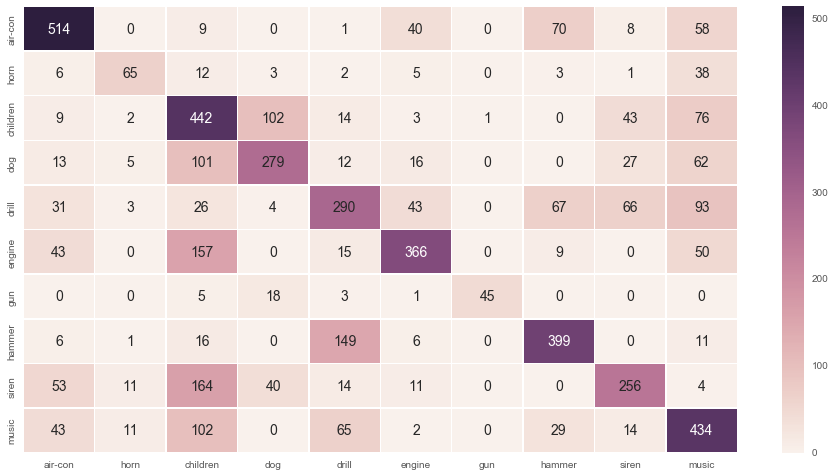

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

labels = ["air-con","horn","children","dog","drill","engine","gun","hammer","siren","music"]
print "Showing Confusion Matrix"
y_prob = model.predict_proba(test_x, verbose=0)
y_pred = np_utils.probas_to_classes(y_prob)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print
    
print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)

In [37]:
sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'samples/us8k/'

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features_array(filename, bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    sound_clip,s = librosa.load(filename)        
    for (start,end) in windows(sound_clip,window_size):
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.logamplitude(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features)


# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print "\n----- ", sound_names[s], "-----"
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_array(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    if len(predictions) == 0: 
        print "No prediction"
        continue
        
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print "Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")"
    print "2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")"

    


-----  air conditioner -----
Top guess:  air conditioner  ( 0.914 )
2nd guess:  siren  ( 0.02 )

-----  car horn -----
Top guess:  car horn  ( 0.873 )
2nd guess:  street music  ( 0.066 )

-----  children playing -----
Top guess:  children playing  ( 0.306 )
2nd guess:  street music  ( 0.199 )

-----  dog bark -----
Top guess:  dog bark  ( 0.652 )
2nd guess:  children playing  ( 0.244 )

-----  drilling -----
Top guess:  drilling  ( 0.595 )
2nd guess:  jackhammer  ( 0.103 )

-----  engine idling -----
Top guess:  engine idling  ( 0.876 )
2nd guess:  street music  ( 0.033 )

-----  gun shot -----
Top guess:  gun shot  ( 0.621 )
2nd guess:  drilling  ( 0.087 )

-----  jackhammer -----
Top guess:  jackhammer  ( 0.794 )
2nd guess:  street music  ( 0.041 )

-----  siren -----
Top guess:  siren  ( 0.97 )
2nd guess:  street music  ( 0.013 )

-----  street music -----
Top guess:  street music  ( 0.729 )
2nd guess:  car horn  ( 0.056 )


Although this model can correctly identify all 10 samples, the accuracy across the entire test set is still only 59%. From my investigations, there do seem to be certain recordings the classifier finds difficult to identify correctly, these tend to be the very short recordings, 1 or 2 seconds long, and recordings that consist of only rapid repetitive noise. 

I managed to get slightly better results with the CNN than my best FFN, an ROC of 0.91 with the CNN, compared to 0.89 with my FFN. My max f-score accuracy for both is about 60%. Getting higher results proved difficult, and there may be diminishing returns for effort given the constraints of the data set, (8000 samples isn't a huge amount, and it does include some repetition of same sound source).

In their paper Salamon and Bello report an accuracy of 73% - but it's worth bearing in mind that their CNN is optimised for a different feature extraction process. I was feeding my implementation of their CNN features extracted with Piczak's method.

From the plot of accuracy indicates whether the model could be trained further (if the accuracy trend is still rising for the final epochs). It will also indicate if the model has over-learned the training dataset, it should show comparable performance on both train and test datasets. If the model is overfitting the accuracy graph will show excellent performance on the training data, and poor performance on the test data.

Ideally, in the loss graph, we should see comparable performance in both the training and validation datasets.


History keys: ['acc', 'loss', 'val_acc', 'val_loss']


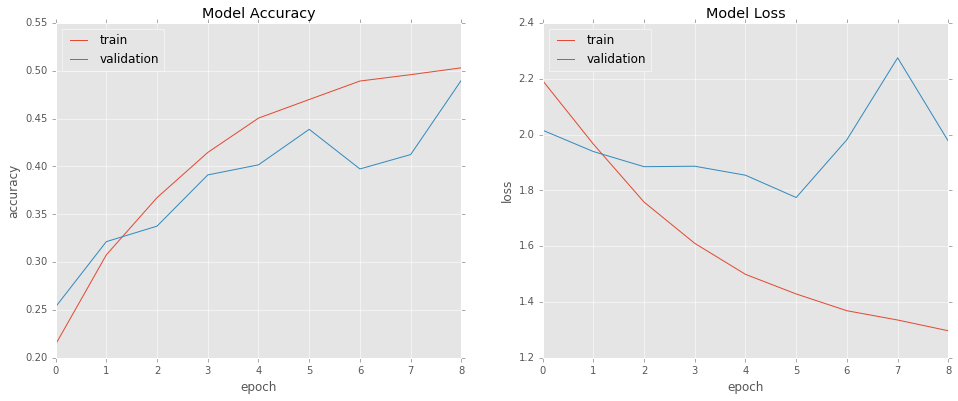

In [21]:
fig = plt.figure(figsize=(16,6))

print "History keys:", (history.history.keys())
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The Accuracy plot on the left provides an insight into whether the model has reached a plateau or could be potentially trained further. It should also show comparable performance on both train and validation datasets, otherwise this would be an indication that the model has over-learned the training dataset.

The Loss plot on the right should show comparable performance in both the training and validation datasets. Should these parallel plots start to diverge, it might be a indication we should stop training earlier. 

#### Next Up

To summarise then, I've managed to implement a general audio classifier capable of distinguishing between different sources of sound. Next, I intend to investigate whether this classifier will be able to effectively recognise some very different sources of sound: birdsong. 